In [6]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,Input
from keras.losses import Huber
from keras.optimizers import Adam
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np


In [7]:
env = gym.make('CartPole-v1',
               render_mode = 'rgb_array')

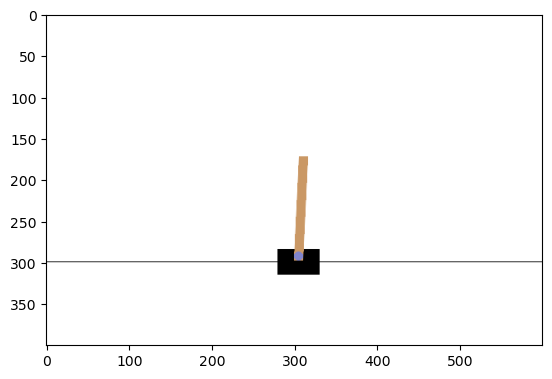

In [8]:
obs,info = env.reset()
img = env.render()
plt.imshow(img)

In [11]:
class DQNAgent:

    def __init__(self,env,n_episodes,epsilon,gamma):

        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_episodes = n_episodes

        self.total_steps = 0
        self.epsilon_dec = 0.993
        self.epsilon_min = 0.05
        self.lr = 1e-3
        self.memory = deque(maxlen = 10000)
        self.target_update_steps = 1000
        self.n_states = 4
        self.n_actions = 2
        self.batch_size = 64

        self.reward_per_10epi = []
        self.epino_forplot = []
        self.all_rewards=[]


        self.online_net = self.make_model()
        self.target_net = self.make_model()
        self.target_net.set_weights(self.online_net.get_weights())

        
        


    def make_model(self):

        model = Sequential([
        Input(shape=(self.env.observation_space.shape[0],)),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(2, activation="linear")
        ])
        model.compile(loss = Huber(delta=1.0), optimizer = Adam(learning_rate=self.lr, clipnorm=1.0))

        return model 

    

    def replay_buffer(self):

        if len(self.memory) < self.batch_size:
            return
        if self.total_steps % 8 != 0:
            return

        states = []
        targets = []
        # for memory in self.memory:
        #     for data in memory:
        #         print(data)
        #     # print(memory)
        #         print()

            
        # print(np.array(self.memory).shape)
        # print(random.sample(self.memory, 1))

        batch_data = random.sample(self.memory, self.batch_size)
        state, actions, reward, next_state, done = zip(*batch_data)
        state, next_state, done = np.array(state), np.array(next_state), np.array(done)
        # print(state)


        qValues = self.online_net.predict(state, verbose = 0)
        target_net = self.target_net.predict(next_state, verbose = 0)
        
        # target_qValues = reward + self.gamma * np.max(target_net, axis = 1) * (1 - np.array(done))
        qValues[np.arange(self.batch_size), actions] = (
        reward + self.gamma * np.max(target_net, axis = 1) * (1 - done)
    )
        
        # for state,action,reward,next_state,done in mini_batch:
        #     target = self.online_net.predict(state,verbose=0)[0] # tyo state ko lagi every action ko q-value return garxa (which will be the training target)
    
        #     if done:
        #         target[action] = reward   # Q(s,a) = =r
        #     else:
        #         target_next = self.target_net.predict(next_state,verbose=0)[0]   # predicts q value for next state
        #         target[action] = reward + self.gamma*np.max(target_next)                  # Q = r + gamma* argmax(Q(nextstate,:))  bellman update
    
            
        #     # states.append(state.reshape(-1))   #flatten
        #     targets.append(target)

        # print(target_qValues)
        self.online_net.fit(state, qValues, epochs = 1, verbose = 0)

        

    

    def select_action(self,state):

        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            # print(state.shape)
            action = np.argmax(self.online_net.predict(state.reshape(1,-1), verbose=0)[0])

        return action
            

    def train(self):

        for episode in range(self.n_episodes):
            state, _ = self.env.reset()
            state = state
            total_reward = 0
            done = False
            # print(type(state))

            
            while not done:

                action = self.select_action(state)
    
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                # print(next_state.shape)
                next_state = next_state
                # print(next_state.shape)
                total_reward += reward
                

                

                self.total_steps += 1

                self.memory.append((state, action, reward, next_state, done))

                state = next_state
                
                self.replay_buffer()

                if self.total_steps % self.target_update_steps == 0:
                    self.target_net.set_weights(self.online_net.get_weights())

                
            self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_dec)
            self.all_rewards.append(total_reward)

            if episode%10 == 0:
                self.epino_forplot.append(episode)
                avg_reward = np.mean(self.all_rewards[-10:])
                self.reward_per_10epi.append(avg_reward)
                
        
            print(f"Episode {episode}, Reward {total_reward}, Epsilon {self.epsilon:.4f}")
            

                
    def plot(self):
        plt.plot(self.epino_forplot, self.reward_per_10epi)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("DQN Training Progress")
        plt.show()
                

    

Episode 0, Reward 67.0, Epsilon 0.9930
Episode 1, Reward 34.0, Epsilon 0.9860
Episode 2, Reward 29.0, Epsilon 0.9791
Episode 3, Reward 43.0, Epsilon 0.9723
Episode 4, Reward 14.0, Epsilon 0.9655
Episode 5, Reward 46.0, Epsilon 0.9587
Episode 6, Reward 16.0, Epsilon 0.9520
Episode 7, Reward 34.0, Epsilon 0.9454
Episode 8, Reward 16.0, Epsilon 0.9387
Episode 9, Reward 13.0, Epsilon 0.9322
Episode 10, Reward 18.0, Epsilon 0.9256
Episode 11, Reward 24.0, Epsilon 0.9192
Episode 12, Reward 19.0, Epsilon 0.9127
Episode 13, Reward 22.0, Epsilon 0.9063
Episode 14, Reward 52.0, Epsilon 0.9000
Episode 15, Reward 17.0, Epsilon 0.8937
Episode 16, Reward 14.0, Epsilon 0.8874
Episode 17, Reward 16.0, Epsilon 0.8812
Episode 18, Reward 26.0, Epsilon 0.8751
Episode 19, Reward 30.0, Epsilon 0.8689
Episode 20, Reward 12.0, Epsilon 0.8628
Episode 21, Reward 24.0, Epsilon 0.8568
Episode 22, Reward 13.0, Epsilon 0.8508
Episode 23, Reward 10.0, Epsilon 0.8449
Episode 24, Reward 40.0, Epsilon 0.8389
Episode 25

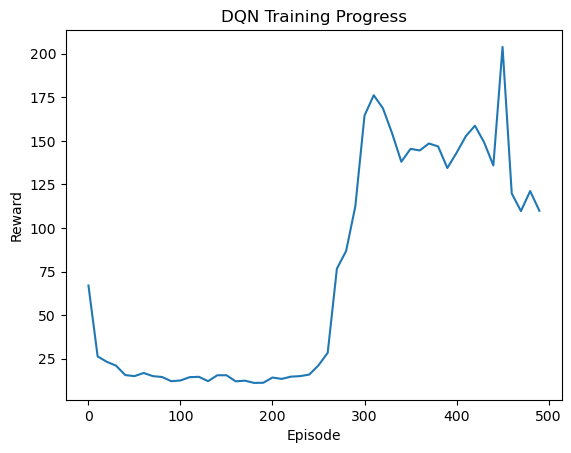

In [12]:
Agent = DQNAgent(env,n_episodes=500, epsilon=1, gamma=0.99)
Agent.train()
Agent.plot()

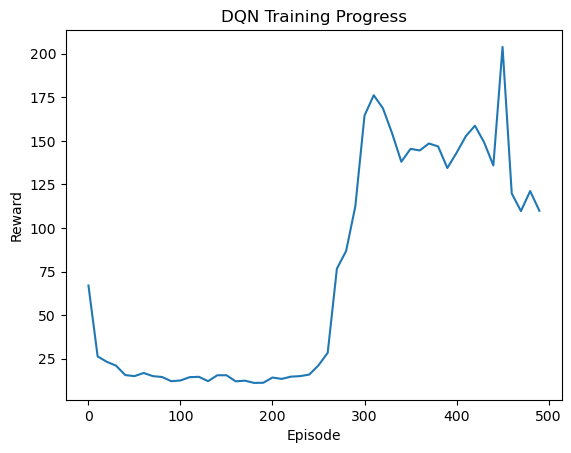

In [16]:
Agent.plot()

In [15]:
Agent.online_net.save("DQN-online_net.keras")
Agent.target_net.save("DQN-target_net.keras")

In [22]:
env = gym.make('CartPole-v1',
               render_mode = 'human')
for i in range(10):
    tot_reward = 0
    state,_ = env.reset()
    state = np.reshape(state,[1,4])
    done = False
    while not done:
        
        action = np.argmax(Agent.target_net.predict(state,verbose=0)[0])
        next_state,reward,terminated,truncated,_ = env.step(action)
        state = np.reshape(next_state, [1,4])
        done = truncated or terminated
        tot_reward += reward
    
    print("Total reward this episode",tot_reward)
env.close()
    
    

Total reward this episode 492.0
Total reward this episode 500.0
Total reward this episode 500.0
Total reward this episode 381.0
Total reward this episode 500.0
Total reward this episode 500.0
Total reward this episode 280.0
Total reward this episode 296.0
Total reward this episode 466.0
Total reward this episode 336.0
